## 0. Setup

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import pickle
import warnings
warnings.filterwarnings('ignore')

# Paths
BASE_DIR = Path('.').resolve().parent
DATA_DIR = BASE_DIR / 'data' / 'processed' / '10sec'
OUTPUT_DIR = DATA_DIR / 'model_ready'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print(f"Base directory: {BASE_DIR}")
print(f"Data directory: {DATA_DIR}")
print(f"Output directory: {OUTPUT_DIR}")

Base directory: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1
Data directory: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\10sec
Output directory: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\10sec\model_ready


In [2]:
# Load dataset
input_file = DATA_DIR / 'nilm_ready_dataset.parquet'
if not input_file.exists():
    input_file = DATA_DIR / 'nilm_ready_dataset.csv'

if input_file.suffix == '.parquet':
    df = pd.read_parquet(input_file)
else:
    df = pd.read_csv(input_file)

df['Time'] = pd.to_datetime(df['Time'])
df = df.sort_values('Time').reset_index(drop=True)

print(f"Loaded: {len(df):,} rows, {len(df.columns)} columns")
print(f"Time range: {df['Time'].min()} → {df['Time'].max()}")
print(f"\nColumns: {list(df.columns)}")

Loaded: 636,854 rows, 16 columns
Time range: 2024-03-14 14:02:20+00:00 → 2024-05-31 23:59:50+00:00

Columns: ['Time', 'Aggregate', 'RangeHood', 'TumbleDryer', 'Stove', 'Oven', 'RainwaterPump', 'Dishwasher', 'HeatPump', 'WashingMachine', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']


## 1. Configuration

In [3]:
# ============================================================
# CONFIGURATION
# ============================================================

# Resolution
RESOLUTION_SEC = 10
SAMPLES_PER_HOUR = 3600 // RESOLUTION_SEC  # 360
SAMPLES_PER_DAY = 24 * SAMPLES_PER_HOUR    # 8640

# Window size (for Transformer input)
# 1 hour = 360 samples at 10sec resolution
WINDOW_SIZE = 360  # 1 hour window

# Block split configuration
BLOCK_DAYS = 7
PATTERN = [0, 0, 0, 0, 1, 2]  # ~66% Train, ~16% Val, ~16% Test

# Appliances to predict
APPLIANCE_COLUMNS = [
    'RangeHood', 'TumbleDryer', 'Stove', 'Oven',
    'RainwaterPump', 'Dishwasher', 'HeatPump', 'WashingMachine'
]

# Input features (Aggregate + temporal)
TEMPORAL_FEATURES = ['hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']
INPUT_FEATURES = ['Aggregate'] + TEMPORAL_FEATURES

print(f"Configuration:")
print(f"  Resolution: {RESOLUTION_SEC}sec")
print(f"  Samples/day: {SAMPLES_PER_DAY}")
print(f"  Window size: {WINDOW_SIZE} ({WINDOW_SIZE * RESOLUTION_SEC / 3600:.1f} hours)")
print(f"  Block size: {BLOCK_DAYS} days")
print(f"  Input features: {len(INPUT_FEATURES)}")
print(f"  Target appliances: {len(APPLIANCE_COLUMNS)}")

Configuration:
  Resolution: 10sec
  Samples/day: 8640
  Window size: 360 (1.0 hours)
  Block size: 7 days
  Input features: 7
  Target appliances: 8


## 2. Block Time-Series Split

In [4]:
def block_time_series_split(
    df: pd.DataFrame,
    block_days: int = 7,
    pattern: list = None,
    samples_per_day: int = 8640,
    time_column: str = 'Time'
) -> tuple:
    """
    Split time-series data into Train/Val/Test using interleaved blocks.
    
    Parameters
    ----------
    df : pd.DataFrame
        Input dataframe with time column
    block_days : int
        Number of days per block (default: 7 for weekly blocks)
    pattern : list
        Assignment pattern. Default: [0,0,0,0,1,2] where 0=Train, 1=Val, 2=Test
    samples_per_day : int
        Number of samples per day (8640 for 10sec resolution)
    time_column : str
        Name of the time column
    
    Returns
    -------
    tuple: (train_df, val_df, test_df)
    """
    if pattern is None:
        pattern = [0, 0, 0, 0, 1, 2]
    
    df = df.copy()
    df[time_column] = pd.to_datetime(df[time_column])
    df = df.sort_values(time_column).reset_index(drop=True)
    
    # Calculate block size
    block_size = block_days * samples_per_day
    
    # Assign block number and set
    df['_block'] = df.index // block_size
    df['_set'] = df['_block'].apply(lambda x: pattern[x % len(pattern)])
    
    # Split
    train_df = df[df['_set'] == 0].drop(columns=['_block', '_set'])
    val_df = df[df['_set'] == 1].drop(columns=['_block', '_set'])
    test_df = df[df['_set'] == 2].drop(columns=['_block', '_set'])
    
    return train_df, val_df, test_df

In [5]:
# Split
train_df, val_df, test_df = block_time_series_split(
    df, 
    block_days=BLOCK_DAYS, 
    pattern=PATTERN,
    samples_per_day=SAMPLES_PER_DAY
)

# Summary
total = len(train_df) + len(val_df) + len(test_df)
print(f"{'Set':<12} {'Rows':>10} {'%':>8} {'Days':>8}")
print("-" * 40)
print(f"{'Train':<12} {len(train_df):>10,} {100*len(train_df)/total:>7.1f}% {len(train_df)/SAMPLES_PER_DAY:>7.1f}")
print(f"{'Validation':<12} {len(val_df):>10,} {100*len(val_df)/total:>7.1f}% {len(val_df)/SAMPLES_PER_DAY:>7.1f}")
print(f"{'Test':<12} {len(test_df):>10,} {100*len(test_df)/total:>7.1f}% {len(test_df)/SAMPLES_PER_DAY:>7.1f}")
print("-" * 40)
print(f"{'Total':<12} {total:>10,}")

Set                Rows        %     Days
----------------------------------------
Train           483,840    76.0%    56.0
Validation       92,534    14.5%    10.7
Test             60,480     9.5%     7.0
----------------------------------------
Total           636,854


## 3. Scaling (MinMax Normalization)

In [6]:
# Columns to scale (all except Time)
feature_columns = [col for col in df.columns if col != 'Time']
print(f"Features to scale ({len(feature_columns)}): {feature_columns}")

Features to scale (15): ['Aggregate', 'RangeHood', 'TumbleDryer', 'Stove', 'Oven', 'RainwaterPump', 'Dishwasher', 'HeatPump', 'WashingMachine', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']


In [7]:
# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit on Train only
scaler.fit(train_df[feature_columns])

# Transform all sets
train_scaled = scaler.transform(train_df[feature_columns])
val_scaled = scaler.transform(val_df[feature_columns])
test_scaled = scaler.transform(test_df[feature_columns])

print(f"Scaled shapes:")
print(f"  Train: {train_scaled.shape}")
print(f"  Val:   {val_scaled.shape}")
print(f"  Test:  {test_scaled.shape}")

print(f"\nValue ranges after scaling:")
print(f"  Train: [{train_scaled.min():.4f}, {train_scaled.max():.4f}]")
print(f"  Val:   [{val_scaled.min():.4f}, {val_scaled.max():.4f}]")
print(f"  Test:  [{test_scaled.min():.4f}, {test_scaled.max():.4f}]")

Scaled shapes:
  Train: (483840, 15)
  Val:   (92534, 15)
  Test:  (60480, 15)

Value ranges after scaling:
  Train: [0.0000, 1.0000]
  Val:   [0.0000, 1.0000]
  Test:  [0.0000, 1.2239]


In [8]:
# Save scaler
scaler_path = OUTPUT_DIR / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"Saved scaler: {scaler_path}")

# Save feature names mapping
feature_mapping = {i: col for i, col in enumerate(feature_columns)}
print(f"\nFeature index mapping:")
for idx, name in feature_mapping.items():
    print(f"  {idx}: {name}")

Saved scaler: C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\10sec\model_ready\scaler.pkl

Feature index mapping:
  0: Aggregate
  1: RangeHood
  2: TumbleDryer
  3: Stove
  4: Oven
  5: RainwaterPump
  6: Dishwasher
  7: HeatPump
  8: WashingMachine
  9: hour_sin
  10: hour_cos
  11: dow_sin
  12: dow_cos
  13: month_sin
  14: month_cos


## 4. Windowing (Sequence Generation)

In [9]:
def create_sequences(
    data: np.ndarray,
    window_size: int,
    input_indices: list,
    target_indices: list,
    stride: int = 1
) -> tuple:
    """
    Create sliding window sequences for Transformer.
    
    Parameters
    ----------
    data : np.ndarray
        Scaled data array (samples, features)
    window_size : int
        Number of time steps per sequence
    input_indices : list
        Column indices for input features (Aggregate + temporal)
    target_indices : list
        Column indices for target appliances
    stride : int
        Step size between windows (default: 1)
    
    Returns
    -------
    tuple: (X, y) arrays
        X shape: (n_samples, window_size, n_input_features)
        y shape: (n_samples, window_size, n_appliances)
    """
    n_samples = (len(data) - window_size) // stride + 1
    
    X = np.zeros((n_samples, window_size, len(input_indices)))
    y = np.zeros((n_samples, window_size, len(target_indices)))
    
    for i in range(n_samples):
        start = i * stride
        end = start + window_size
        X[i] = data[start:end, input_indices]
        y[i] = data[start:end, target_indices]
    
    return X, y

In [10]:
# Get column indices
input_indices = [feature_columns.index(f) for f in INPUT_FEATURES]
target_indices = [feature_columns.index(f) for f in APPLIANCE_COLUMNS if f in feature_columns]

print(f"Input feature indices: {input_indices}")
print(f"Input features: {[feature_columns[i] for i in input_indices]}")
print(f"\nTarget indices: {target_indices}")
print(f"Target appliances: {[feature_columns[i] for i in target_indices]}")

Input feature indices: [0, 9, 10, 11, 12, 13, 14]
Input features: ['Aggregate', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']

Target indices: [1, 2, 3, 4, 5, 6, 7, 8]
Target appliances: ['RangeHood', 'TumbleDryer', 'Stove', 'Oven', 'RainwaterPump', 'Dishwasher', 'HeatPump', 'WashingMachine']


In [11]:
# Use stride > 1 to reduce number of sequences (memory efficiency)
# stride = SAMPLES_PER_HOUR // 6 = 60 → sequences every 10 minutes
STRIDE = 60

print(f"Creating sequences with window={WINDOW_SIZE}, stride={STRIDE}...")
print(f"(One window every {STRIDE * RESOLUTION_SEC / 60:.0f} minutes)")

# Create sequences
X_train, y_train = create_sequences(train_scaled, WINDOW_SIZE, input_indices, target_indices, stride=STRIDE)
X_val, y_val = create_sequences(val_scaled, WINDOW_SIZE, input_indices, target_indices, stride=STRIDE)
X_test, y_test = create_sequences(test_scaled, WINDOW_SIZE, input_indices, target_indices, stride=STRIDE)

print(f"\nSequence shapes:")
print(f"  X_train: {X_train.shape} (samples, window, features)")
print(f"  y_train: {y_train.shape} (samples, window, appliances)")
print(f"  X_val:   {X_val.shape}")
print(f"  y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape}")
print(f"  y_test:  {y_test.shape}")

Creating sequences with window=360, stride=60...
(One window every 10 minutes)

Sequence shapes:
  X_train: (8059, 360, 7) (samples, window, features)
  y_train: (8059, 360, 8) (samples, window, appliances)
  X_val:   (1537, 360, 7)
  y_val:   (1537, 360, 8)
  X_test:  (1003, 360, 7)
  y_test:  (1003, 360, 8)


## 5. Verify Sequences

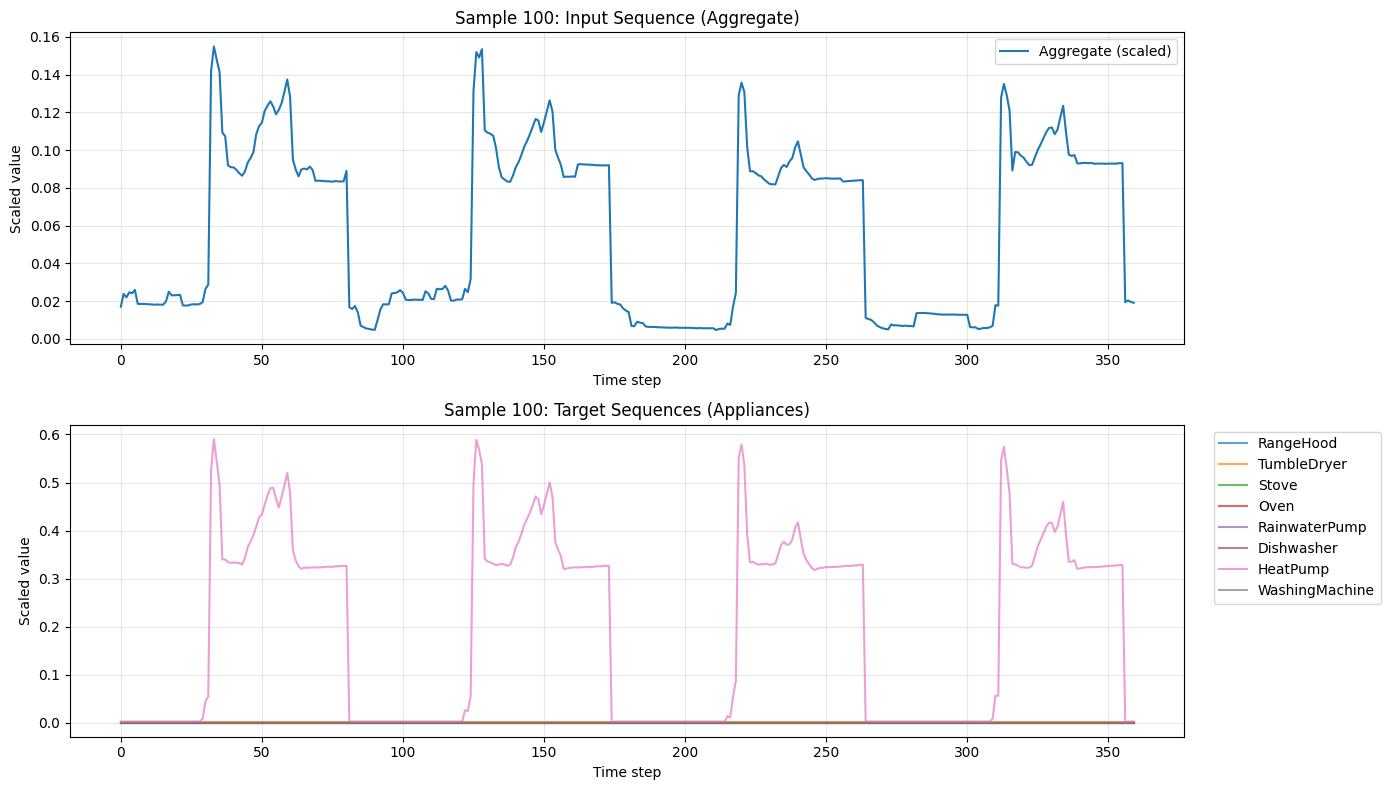

In [12]:
import matplotlib.pyplot as plt

# Plot a sample sequence
sample_idx = 100

fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# Input (Aggregate)
ax1 = axes[0]
ax1.plot(X_train[sample_idx, :, 0], label='Aggregate (scaled)')
ax1.set_xlabel('Time step')
ax1.set_ylabel('Scaled value')
ax1.set_title(f'Sample {sample_idx}: Input Sequence (Aggregate)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Targets (Appliances)
ax2 = axes[1]
target_names = [feature_columns[i] for i in target_indices]
for i, name in enumerate(target_names):
    ax2.plot(y_train[sample_idx, :, i], label=name, alpha=0.7)
ax2.set_xlabel('Time step')
ax2.set_ylabel('Scaled value')
ax2.set_title(f'Sample {sample_idx}: Target Sequences (Appliances)')
ax2.legend(bbox_to_anchor=(1.02, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Export Numpy Arrays

In [13]:
print('='*70)
print('💾 EXPORTING NUMPY ARRAYS')
print('='*70)

# Save arrays
np.save(OUTPUT_DIR / 'X_train.npy', X_train)
np.save(OUTPUT_DIR / 'y_train.npy', y_train)
np.save(OUTPUT_DIR / 'X_val.npy', X_val)
np.save(OUTPUT_DIR / 'y_val.npy', y_val)
np.save(OUTPUT_DIR / 'X_test.npy', X_test)
np.save(OUTPUT_DIR / 'y_test.npy', y_test)

print(f'\n✅ Arrays saved to {OUTPUT_DIR}:')
for f in OUTPUT_DIR.glob('*.npy'):
    size_mb = f.stat().st_size / 1024 / 1024
    print(f'   {f.name}: {size_mb:.1f} MB')

💾 EXPORTING NUMPY ARRAYS

✅ Arrays saved to C:\Users\gamek\School\TeamProject\MTS3-MCTE-Team-Project-Energy-G1\data\processed\10sec\model_ready:
   X_test.npy: 19.3 MB
   X_train.npy: 154.9 MB
   X_val.npy: 29.6 MB
   y_test.npy: 22.0 MB
   y_train.npy: 177.1 MB
   y_val.npy: 33.8 MB


In [14]:
# Save metadata
metadata = {
    'resolution_sec': RESOLUTION_SEC,
    'window_size': WINDOW_SIZE,
    'stride': STRIDE,
    'input_features': INPUT_FEATURES,
    'target_appliances': [feature_columns[i] for i in target_indices],
    'feature_columns': feature_columns,
    'shapes': {
        'X_train': X_train.shape,
        'y_train': y_train.shape,
        'X_val': X_val.shape,
        'y_val': y_val.shape,
        'X_test': X_test.shape,
        'y_test': y_test.shape
    }
}

with open(OUTPUT_DIR / 'metadata.pkl', 'wb') as f:
    pickle.dump(metadata, f)

print(f'\n✅ Metadata saved')
print(f'\nMetadata:')
for k, v in metadata.items():
    print(f'  {k}: {v}')


✅ Metadata saved

Metadata:
  resolution_sec: 10
  window_size: 360
  stride: 60
  input_features: ['Aggregate', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']
  target_appliances: ['RangeHood', 'TumbleDryer', 'Stove', 'Oven', 'RainwaterPump', 'Dishwasher', 'HeatPump', 'WashingMachine']
  feature_columns: ['Aggregate', 'RangeHood', 'TumbleDryer', 'Stove', 'Oven', 'RainwaterPump', 'Dishwasher', 'HeatPump', 'WashingMachine', 'hour_sin', 'hour_cos', 'dow_sin', 'dow_cos', 'month_sin', 'month_cos']
  shapes: {'X_train': (8059, 360, 7), 'y_train': (8059, 360, 8), 'X_val': (1537, 360, 7), 'y_val': (1537, 360, 8), 'X_test': (1003, 360, 7), 'y_test': (1003, 360, 8)}


---
## ✅ Pretraining Complete

### Output Summary
| File | Shape | Description |
|------|-------|-------------|
| X_train.npy | (N, 360, 7) | Train input sequences |
| y_train.npy | (N, 360, 8) | Train target sequences |
| X_val.npy | (N, 360, 7) | Validation input |
| y_val.npy | (N, 360, 8) | Validation target |
| X_test.npy | (N, 360, 7) | Test input |
| y_test.npy | (N, 360, 8) | Test target |
| scaler.pkl | - | MinMaxScaler for inference |
| metadata.pkl | - | Configuration and feature names |

### Input Features (7)
- Aggregate (total consumption)
- hour_sin, hour_cos
- dow_sin, dow_cos
- month_sin, month_cos

### Target Appliances (8)
1. RangeHood
2. TumbleDryer
3. Stove
4. Oven
5. RainwaterPump
6. Dishwasher
7. HeatPump
8. WashingMachine

### Next Steps
- Train Transformer model on these sequences
- Compare performance with 15min Seq2Seq baseline